# L06-07 Manual Logistic Regression

In [1]:
import torch

In [10]:
# data
import numpy as np

data = np.loadtxt('dataset/diabetes.csv.gz', delimiter=',', dtype=np.float32)
train_size = int(data.shape[0]*0.8)
test_size = data.shape[0] - train_size
train_data = data[:-test_size,:]
test_data = data[-test_size:,:]

x_data = torch.from_numpy(train_data[:,:-1])
y_data = torch.from_numpy(train_data[:,[-1]]) # if [:,-1], torch.Size([759])
print(y_data.size())

torch.Size([607, 1])


In [11]:
# model
import math

class LogisticRegression(torch.nn.Module):
    def __init__(self):
        self.weight = torch.Tensor(np.ones([8,1]))
        self.weight = torch.Tensor([[-0.8260],
                                    [-3.4521],
                                    [ 0.1129],
                                    [-0.6267],
                                    [-0.2119],
                                    [-2.4874],
                                    [-1.0655],
                                    [ 0.0169]])
        self.weight.requires_grad=True
        self.bias = torch.Tensor(np.empty([1]))
        self.bias.requires_grad=True
        
    def __call__(self, *args, **kargs):
        y = torch.Tensor(np.empty([test_size,1]))
        for i, x in enumerate(args[0]):
            y_pred = x.matmul(self.weight) + self.bias
            y_pred = 1 / (1 + math.pow(math.e, -y_pred)) #  pow() will convert float to int; without [0] y_pred will be float
            y[i][0] = y_pred
        return y_pred

    def forward(self, x):
        y_pred = x.matmul(self.weight) + self.bias
        y_pred = 1 / (1 + torch.exp(-y_pred)) # pow() and math.pow() donot support calculate grad automatically
        return y_pred
    
    def parameters(self):
        # return {'weight':self.weight, 'bias':self.bias}
        return self.weight, self.bias
    
logisticModel = LogisticRegression()

In [12]:
# loss
class BCELoss:
    def __init__(self):
        pass
    
    def loss(self, y_pred, y):
        loss = -(y*torch.log(y_pred) + (1-y)*torch.log(1-y_pred)) # math.log donot support calculate grad automatically
        loss = torch.Tensor(np.ones([1,train_size])).matmul(loss)
        loss /= train_size
        return loss
    
criterion = BCELoss()

In [13]:
# optimizer
class GD:
    def __init__(self, params, lr=0.01):
        print(params)
        # self.weight = params['weight']
        # self.bias = params['bias']
        self.params = params
        self.lr = lr
        
    def step(self):
        # self.weight.data -= self.lr*self.weight.grad.data
        # self.bias.data -= self.lr*self.bias.grad.data
        for param in self.params:
            param.data -= self.lr*param.grad.data
        
    def zero_grad(self):
        # self.weight.grad.data.zero_()
        # self.bias.grad.data.zero_()
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()
                
optimizer = GD(logisticModel.parameters(), lr=0.01)

(tensor([[-0.8260],
        [-3.4521],
        [ 0.1129],
        [-0.6267],
        [-0.2119],
        [-2.4874],
        [-1.0655],
        [ 0.0169]], requires_grad=True), tensor([1.], requires_grad=True))


In [14]:
# train
epoch = 0
train_loss = []

while True:
# for epoch in  range(100):
    y_pred = logisticModel.forward(x_data)
    loss = criterion.loss(y_pred, y_data)
    loss.requires_grad_()
    train_loss.append(loss.item())
    
    loss.backward() # pytorch helps refresh grad automatically
    optimizer.step()
    optimizer.zero_grad()
    
    if(loss.item() <= 1e-5 or epoch >= 40000):
        break
    else:
        epoch += 1

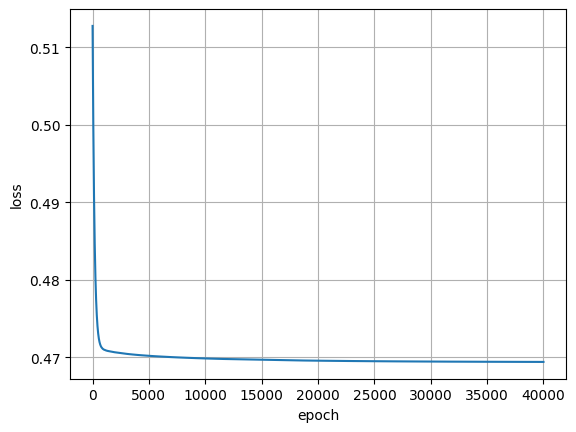

In [15]:
# train_plot
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.show()

In [16]:
# train_param
print('w=', logisticModel.weight.data)
print('b=', logisticModel.bias.item())

w= tensor([[-0.8167],
        [-3.4830],
        [ 0.2297],
        [-0.5289],
        [-0.2398],
        [-2.7852],
        [-1.0392],
        [-0.0227]])
b= 0.23667974770069122


In [17]:
# test
x_test = torch.from_numpy(test_data[:,:-1])
y_test_truth = torch.from_numpy(test_data[:,[-1]])

y_test_pred = logisticModel(x_test)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0) 
accurate_rate = (y_test_pred == y_test_truth.tolist()).sum() / test_size
# y_test_pred = y_test_pred.round()
# accurate_rate = (y_test_pred == y_test_truth).sum() / test_size
print('accurate_rate=', accurate_rate)

accurate_rate= 0.6447368421052632
